# MIMIC IV Exploration 

This project is an exploration of the MIMIC IV dataset. The MIMIC IV dataset is a large, freely available database comprising de-identified health-related data associated with over 180,000 distinct patients who were admitted to the hospital. First we will explore which services are available in the dataset and then we will explore the data of the patients who were admitted to the hospital.

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tabulate import tabulate

In [190]:
admissions = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/admissions.csv")
poe = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/poe.csv")
services = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/services.csv")

In [191]:
patients = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/patients.csv")

In [192]:
np.unique(admissions['subject_id']).shape

(180733,)

# Inspect the most frequent services in the hospital

In [193]:
services['curr_service'].value_counts()

curr_service
MED      225914
CMED      42883
SURG      40878
OMED      26064
ORTHO     21373
NMED      21110
OBS       19511
NSURG     13081
CSURG     10647
VSURG     10188
PSYCH      7699
TRAUM      7232
GYN        6371
GU         5551
TSURG      4537
PSURG      3794
ENT        1130
EYE          39
DENT         27
Name: count, dtype: int64

Based on the data above the Cardiac Medical service is the most frequent service in the hospital, outside of generalized Internal Medicine. This project will explore the patient outcomes for patients who were admitted to the hospital under the Cardiac Medical service.

# CMED	Cardiac Medical - for non-surgical cardiac related admissions

In this project the main focus will be on Cardiac Medical non-surgical cardiac related patients. This service is the highest number of rows in the services under the current service column that is not under just generalized "Internal Medicine" or MED in the database. As this service is the most common speciality service, there seems to be a high need to understand the outcomes and the factors that contribute to the outcomes of these patients.

We will explore all of the critical asepcts of each hospital stay for the Cardiac Patients. 

In [194]:
# Filter for rows where curr_service is 'CMED'
cmed_patients = services[services['curr_service'] == 'CMED']

# Select only the subject_id and hadm_id columns
cmed_patients = cmed_patients[['subject_id', 'hadm_id']].drop_duplicates()

# Reset the index
cmed_patients = cmed_patients.reset_index(drop=True)

# Display the first few rows to verify
print(cmed_patients.head())
print("Number of rows: ", cmed_patients.shape[0])


   subject_id   hadm_id
0    10000635  26134563
1    10000980  24947999
2    10000980  26913865
3    10000980  29654838
4    10000980  29659838
Number of rows:  42459


## First we will explore the aspects of death for patients admitted to the hospital under the Cardiac Medical service.

### Percent of Patients who died in the hospital under the Cardiac Medical Service

In [195]:
# Merge the CMED patients with the admissions data
cardiac_admissions = pd.merge(cmed_patients, admissions, on=['subject_id', 'hadm_id'], how='left')

# Add the age and gender columns from the patients file to our cardiac_admissions DataFrame
patients = patients[['subject_id', 'anchor_age', 'gender']]

# Merge cardiac_admissions with patients
cardiac_admissions = pd.merge(
    cardiac_admissions,
    patients,
    on='subject_id',
    how='left'
)

# Number of unique patients in the cardiac_admissions DataFrame
num_patients = cardiac_admissions['subject_id'].nunique()
print(f"Number of unique cardiac patients: {num_patients}")

# Count the number of CMED patients with a recorded deathtime
deaths_count = cardiac_admissions['deathtime'].notna().sum()


# Calculate the percentage of CMED patients who died
death_percentage = (deaths_count / num_patients) * 100

# Create a new DataFrame with death information
death_info = cardiac_admissions[cardiac_admissions['deathtime'].notna()]

print(f"Total CMED hosptializations: {len(cmed_patients)}")
print(f"Number of CMED patients with recorded deaths: {deaths_count}")
print(f"Percentage of CMED patients who died within one year of last discharge: {death_percentage:.2f}%")


print("\nFirst few CMED patients with recorded deaths:")
print(death_info.shape)
death_info.head()

Number of unique cardiac patients: 25079
Total CMED hosptializations: 42459
Number of CMED patients with recorded deaths: 1162
Percentage of CMED patients who died within one year of last discharge: 4.63%

First few CMED patients with recorded deaths:
(1162, 18)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,anchor_age,gender
24,10003400,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P99U21,TRANSFER FROM HOSPITAL,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,72,F
48,10010058,26359957,2147-11-18 02:34:00,2147-11-19 04:00:00,2147-11-19 04:00:00,EW EMER.,P83ML7,PHYSICIAN REFERRAL,DIED,Other,?,MARRIED,ASIAN - SOUTH EAST ASIAN,2147-11-18 00:50:00,2147-11-18 03:19:00,1,80,M
50,10010471,29842315,2155-12-02 19:36:00,2155-12-07 15:30:00,2155-12-07 15:30:00,EW EMER.,P04X8Y,EMERGENCY ROOM,DIED,Medicare,ENGLISH,WIDOWED,WHITE,2155-12-02 16:00:00,2155-12-02 20:33:00,1,89,F
104,10023117,21607814,2175-07-06 15:57:00,2175-07-20 00:00:00,2175-07-20 22:50:00,OBSERVATION ADMIT,P49NLZ,EMERGENCY ROOM,DIED,Medicare,ENGLISH,WIDOWED,WHITE,2175-07-06 14:02:00,2175-07-06 17:41:00,1,53,M
135,10026161,24614671,2133-11-11 07:15:00,2133-11-15 18:05:00,2133-11-15 18:05:00,SURGICAL SAME DAY ADMISSION,P68URZ,PHYSICIAN REFERRAL,DIED,Medicare,ENGLISH,DIVORCED,WHITE,NaN,NaN,1,78,M


### Inspect the time to death from admission in the patients who died in the CMED service

The dates and times are de-identified in the MIMIC IV dataset, there is an offset of the actual time for each patient, but the times for each patient hosptial stay are still relative to each other.

In [196]:
import warnings
warnings.filterwarnings('ignore')
# Convert admittime and deathtime to datetime
death_info['admittime'] = pd.to_datetime(death_info['admittime'])
death_info['deathtime'] = pd.to_datetime(death_info['deathtime'])
death_info['dischtime'] = pd.to_datetime(death_info['dischtime'])

# Calculate time from admit to death
death_info['time_to_death'] = death_info['deathtime'] - death_info['admittime']

# Remove rows with negative time_to_death
death_info_filtered = death_info[death_info['time_to_death'] >= pd.Timedelta(0)]

# Calculate average time to death
average_time_to_death = death_info_filtered['time_to_death'].mean()

# Print summary statistics
print(death_info_filtered[['admittime', 'deathtime', 'time_to_death']].head())
print(f"\nNumber of records removed due to negative time_to_death: {len(death_info) - len(death_info_filtered)}")
print(f"Average time from admission to death: {average_time_to_death}")

# Number of rows where death was within discharge time
within_discharge = death_info_filtered[death_info_filtered['deathtime'] <= death_info_filtered['dischtime']]
print(f"Number of deaths within discharge time: {within_discharge.shape[0]}")
# Calculate percentage of deaths within discharge time
within_discharge_percentage = (within_discharge.shape[0] / death_info_filtered.shape[0]) * 100
print(f"Percentage of deaths within discharge time: {within_discharge_percentage:.2f}%")

# Calculate median time to death
median_time_to_death = death_info_filtered['time_to_death'].median()
print(f"Median time from admission to death: {median_time_to_death}")

# Calculate min and max time to death
min_time_to_death = death_info_filtered['time_to_death'].min()
max_time_to_death = death_info_filtered['time_to_death'].max()
print(f"Minimum time from admission to death: {min_time_to_death}")
print(f"Maximum time from admission to death: {max_time_to_death}")

              admittime           deathtime    time_to_death
24  2137-08-04 00:07:00 2137-09-02 17:05:00 29 days 16:58:00
48  2147-11-18 02:34:00 2147-11-19 04:00:00  1 days 01:26:00
50  2155-12-02 19:36:00 2155-12-07 15:30:00  4 days 19:54:00
104 2175-07-06 15:57:00 2175-07-20 22:50:00 14 days 06:53:00
135 2133-11-11 07:15:00 2133-11-15 18:05:00  4 days 10:50:00

Number of records removed due to negative time_to_death: 3
Average time from admission to death: 8 days 19:30:16.307161346
Number of deaths within discharge time: 1097
Percentage of deaths within discharge time: 94.65%
Median time from admission to death: 5 days 16:29:00
Minimum time from admission to death: 0 days 00:26:00
Maximum time from admission to death: 133 days 02:31:00


#### Inspect patients who died after discharge from the hospital under the Cardiac Medical service

In [222]:
# Filter for patients who died after discharge
post_discharge_deaths = death_info_filtered[death_info_filtered['deathtime'] > death_info_filtered['dischtime']]

# Calculate length of stay in days
post_discharge_deaths['length_of_stay'] = (post_discharge_deaths['dischtime'] - post_discharge_deaths['admittime']).dt.total_seconds() / (24 * 60 * 60)

# Calculate average length of stay
avg_stay = post_discharge_deaths['length_of_stay'].mean()

print(f"Average number of days people were in the hospital that died after discharge: {avg_stay:.2f}")

# Additional analysis
print(f"Number of patients who died after discharge: {len(post_discharge_deaths)}")
print(f"Shortest stay: {post_discharge_deaths['length_of_stay'].min():.2f} days")
print(f"Longest stay: {post_discharge_deaths['length_of_stay'].max():.2f} days")

# Calculate time between discharge and death
post_discharge_deaths['time_to_death'] = (post_discharge_deaths['deathtime'] - post_discharge_deaths['dischtime']).dt.total_seconds() / (24 * 60 * 60)
avg_time_to_death = post_discharge_deaths['time_to_death'].mean()

print(f"Average time between discharge and death: {avg_time_to_death:.2f} days")

Average number of days people were in the hospital that died after discharge: 9.59
Number of patients who died after discharge: 62
Shortest stay: -0.94 days
Longest stay: 63.32 days
Average time between discharge and death: 0.80 days


### Patients who died within discharge time
We will focus on extracting insights from the patients who died in the hospital under the Cardiac Medical service using the filterd within_discharge dataframe. We will use these subject_id/hadm_id pairs to extract the conditions, prescriptions, and procedures and lab results for these patients.

In [197]:
within_discharge.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,anchor_age,gender,time_to_death
24,10003400,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P99U21,TRANSFER FROM HOSPITAL,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,72,F,29 days 16:58:00
48,10010058,26359957,2147-11-18 02:34:00,2147-11-19 04:00:00,2147-11-19 04:00:00,EW EMER.,P83ML7,PHYSICIAN REFERRAL,DIED,Other,?,MARRIED,ASIAN - SOUTH EAST ASIAN,2147-11-18 00:50:00,2147-11-18 03:19:00,1,80,M,1 days 01:26:00
50,10010471,29842315,2155-12-02 19:36:00,2155-12-07 15:30:00,2155-12-07 15:30:00,EW EMER.,P04X8Y,EMERGENCY ROOM,DIED,Medicare,ENGLISH,WIDOWED,WHITE,2155-12-02 16:00:00,2155-12-02 20:33:00,1,89,F,4 days 19:54:00
135,10026161,24614671,2133-11-11 07:15:00,2133-11-15 18:05:00,2133-11-15 18:05:00,SURGICAL SAME DAY ADMISSION,P68URZ,PHYSICIAN REFERRAL,DIED,Medicare,ENGLISH,DIVORCED,WHITE,NaN,NaN,1,78,M,4 days 10:50:00
227,10055344,29209451,2171-10-31 19:37:00,2171-11-02 17:05:00,2171-11-02 17:05:00,EW EMER.,P23URY,EMERGENCY ROOM,DIED,Other,?,MARRIED,BLACK/CAPE VERDEAN,2171-10-31 14:50:00,2171-10-31 15:10:00,1,83,M,1 days 21:28:00


### Filter for cardiac patients who did not die at within one year of discharge to compare the ones who died

Filter on subject_id as some patients were admitted multiple times and we want to focus on the patients who were admitted that did not die within one year of discharge, because some patients who died were admitted multiple times so we want to filter them out. 

In [198]:
# Total cardiac admissions number 
cardiac_admissions.shape[0]

42459

In [199]:
# Total admissions for patients who survived more than one year after discharge
cardiac_admissions_survived = cardiac_admissions[~cardiac_admissions['subject_id'].isin(within_discharge['subject_id'])]
cardiac_admissions_survived.shape[0]

40466

In [200]:
# How many times those who died were admitted in total 
cardiac_admissions.shape[0]  - cardiac_admissions_survived.shape[0]

1993

In [225]:
# number of those in cardiac_admissions_death who had multiple admissions in cardiac_admissions

# Filter cardiac_admissions to only include subject_ids of patients who died
deceased_admissions = cardiac_admissions[cardiac_admissions['subject_id'].isin(within_discharge['subject_id'])]

# Count how many of these deceased patients had multiple admissions
multiple_admissions_count = deceased_admissions['subject_id'].duplicated().sum()

print(f"Count of additional admissions (prior to death) for those who died in CMED care: {multiple_admissions_count}")

Count of additional admissions (prior to death) for those who died in CMED care: 896


In [202]:
deceased_admissions['subject_id'].duplicated().value_counts()

subject_id
False    1097
True      896
Name: count, dtype: int64

In [203]:
deceased_admissions['subject_id'].unique().shape

(1097,)

In [204]:
multiple_admissions_unique = deceased_admissions['subject_id'].value_counts()[deceased_admissions['subject_id'].value_counts() > 1].count()
print(f"Number of unique deceased patients with multiple admissions: {multiple_admissions_unique}")

Number of unique deceased patients with multiple admissions: 350


Above we can see that 350 patients had multiple admissions and died within one year of discharge. 

### Now we will compare the death proportions for patients based on their marital status

In [205]:
cardiac_admissions_no_na_marital = cardiac_admissions.dropna(subset=['marital_status'])
# Chi square test for independence between martial status and death
observed = pd.crosstab(cardiac_admissions_no_na_marital['marital_status'], cardiac_admissions_no_na_marital['deathtime'].notna())
chi2, p, dof, expected = stats.chi2_contingency(observed)
print(f"Chi-square test statistic: {chi2}")
print(f"p-value: {p}")
observed

Chi-square test statistic: 26.08434911001403
p-value: 9.157329139649442e-06


deathtime,False,True
marital_status,,
DIVORCED,3100,75
MARRIED,21159,497
SINGLE,9426,208
WIDOWED,6779,230


In [206]:
# Reference category as married for post-hoc analysis
reference_category = 'MARRIED'

# Perform post-hoc analysis
posthoc_results = []

for category in cardiac_admissions_no_na_marital['marital_status'].unique():
    if category != reference_category:
        observed = pd.crosstab(cardiac_admissions_no_na_marital['marital_status'] == category, cardiac_admissions_no_na_marital['deathtime'].notna())
        chi2, p, dof, expected = stats.chi2_contingency(observed)
        posthoc_results.append({'Category': category, 'p-value': p})


posthoc_results_df = pd.DataFrame(posthoc_results)

# Sort the results by p-value
posthoc_results_df = posthoc_results_df.sort_values(by='p-value')
print(posthoc_results_df)

   Category       p-value
0   WIDOWED  5.749534e-07
1    SINGLE  4.885415e-02
2  DIVORCED  8.274272e-01


Based on the knowledge we have from the data above, there is no significant difference between the death proportions for those who are married and those who are divorced. There the significance for the difference between married and single is just below our .05 threshold. Those who are widowed have a significantly higher death proportion than those who are married.

We will explore a possible confounding factor in this relationship, the age of the patients.

### Compare the age of patients based on their marital status 

In [207]:
# Pairwise Tukey post-hoc test for age by marital status
# Perform Tukey post-hoc test
tukey_results = pairwise_tukeyhsd(cardiac_admissions_no_na_marital['anchor_age'], cardiac_admissions_no_na_marital['marital_status'])

# Print the summary of the test
print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj  lower   upper  reject
------------------------------------------------------
DIVORCED MARRIED   2.6311   0.0   2.001  3.2613   True
DIVORCED  SINGLE  -5.5469   0.0 -6.2255 -4.8683   True
DIVORCED WIDOWED  14.9387   0.0 14.2293 15.6481   True
 MARRIED  SINGLE   -8.178   0.0 -8.5841 -7.7719   True
 MARRIED WIDOWED  12.3075   0.0 11.8518 12.7633   True
  SINGLE WIDOWED  20.4856   0.0  19.965 21.0062   True
------------------------------------------------------


As seen above from the pairwise comparison of the ages of each marital status, there are significant differences between all of the groups. Age is a confounding variable in the death proportions of the patients, thus we cannot make any conclusions about the death proportions of the patients based on their marital status without controlling for age.

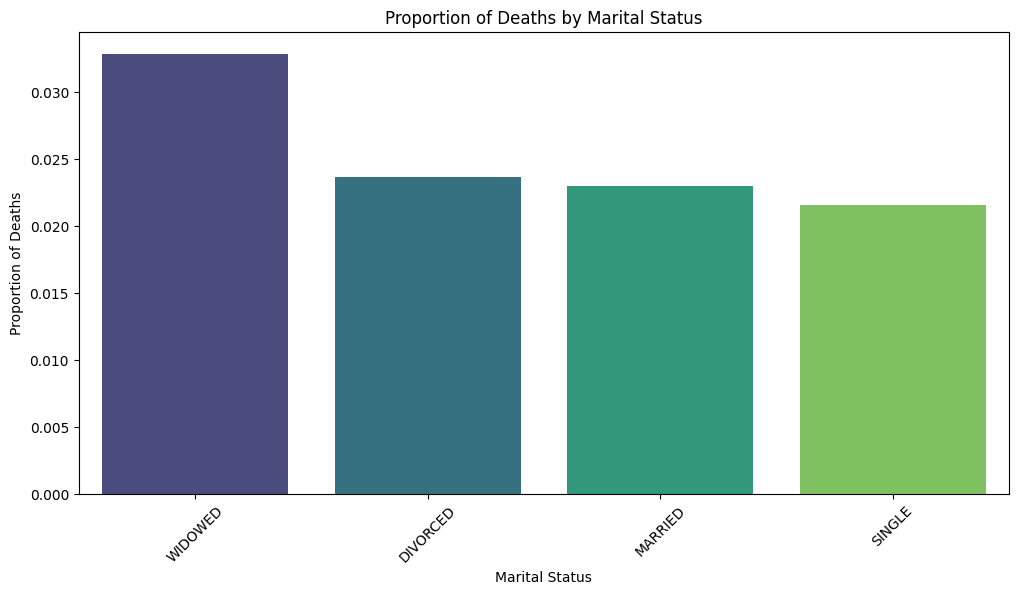

In [208]:
# Proportions of each matial status category's death rate
proportions = cardiac_admissions_no_na_marital.groupby('marital_status')['deathtime'].apply(lambda x: x.notna().sum() / len(x)).reset_index()
proportions.columns = ['marital_status', 'death_rate']

# Sort the proportions
proportions = proportions.sort_values(by='death_rate', ascending=False)

# Plot the proportions
plt.figure(figsize=(12, 6))
sns.barplot(data=proportions, x='marital_status', y='death_rate', hue='marital_status', palette='viridis')
plt.title('Proportion of Deaths by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Deaths')
plt.xticks(rotation=45)
plt.show()

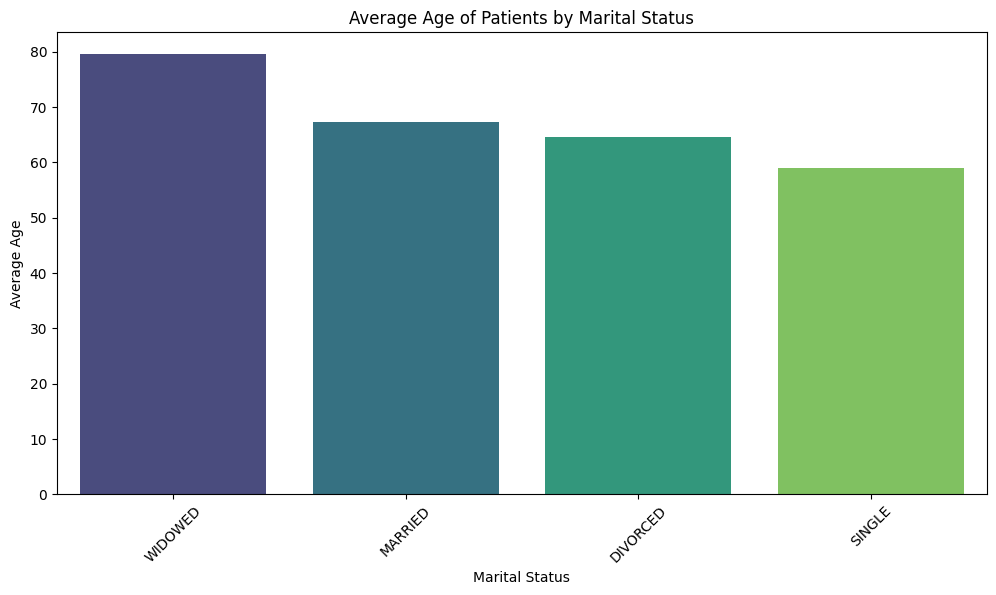

In [209]:
# Average age of patients for each marital status
average_age = cardiac_admissions_no_na_marital.groupby('marital_status')['anchor_age'].mean().reset_index()
average_age.columns = ['marital_status', 'average_age']

# Sort the average age
average_age = average_age.sort_values(by='average_age', ascending=False)

# Plot the average age
plt.figure(figsize=(12, 6))
sns.barplot(data=average_age, x='marital_status', y='average_age', hue='marital_status', palette='viridis')
plt.title('Average Age of Patients by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Average Age')
plt.xticks(rotation=45)
plt.show()

## Moving onto more exploration of the patients who were admitted to the hospital under the Cardiac Medical service

We will inspect more of the aspects to the types of treatments and procedures that the patients received during their hospital stay for the Cardiac Medical service to better understand the outcomes of these patients.

## Procedures for the Cardiac Medical Patients

In [210]:
# Procedures from patient's hosptial stay
procedures = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/procedures_icd.csv")
procedure_desc = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/d_icd_procedures.csv")

In [226]:
d_icd_procedures = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/d_icd_procedures.csv")

In [211]:
# Merge CMED patients with procedures
cardiac_procedures = pd.merge(
    cmed_patients,
    procedures,
    on=['subject_id', 'hadm_id'],
    how='inner'
)

# Merge the procedures with the descriptions
cardiac_procedures = pd.merge(cardiac_procedures, procedure_desc, on=['icd_code', 'icd_version'], how='left')

# Summary statistics
print("\nSummary statistics:")
print(f"Total number of procedures for CMED patients: {len(cardiac_procedures)}")
print(f"Number of unique CMED patients who had procedures: {cardiac_procedures['subject_id'].nunique()}")
print(f"Number of unique hospitalizations with procedures: {cardiac_procedures['hadm_id'].nunique()}")

# Count the most common procedures
top_procedures = cardiac_procedures['long_title'].value_counts().head(10)
print("\nTop 10 most common procedures:")
print(top_procedures)

# Print the number of procedures per hospitalization
procedures_per_hospitalization = cardiac_procedures.groupby('hadm_id').size().describe()
print("\nNumber of procedures per hospitalization:")
print(procedures_per_hospitalization)

# Check the first few rows of the merged dataframe
print("\nFirst few rows of the merged dataframe:")
cardiac_procedures.head()


Summary statistics:
Total number of procedures for CMED patients: 105152
Number of unique CMED patients who had procedures: 18671
Number of unique hospitalizations with procedures: 26775

Top 10 most common procedures:
long_title
Coronary arteriography using two catheters                        8293
Left heart cardiac catheterization                                5396
Percutaneous transluminal coronary angioplasty [PTCA]             4982
Procedure on single vessel                                        4593
Insertion of drug-eluting coronary artery stent(s)                3445
Insertion of one vascular stent                                   3170
Fluoroscopy of Multiple Coronary Arteries using Other Contrast    3074
Combined right and left heart cardiac catheterization             1842
Extracorporeal circulation auxiliary to open heart surgery        1385
Diagnostic ultrasound of heart                                    1384
Name: count, dtype: int64

Number of procedures per hospita

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version,long_title
0,10000635,26134563,1,2136-06-19,3734,9,Excision or destruction of other lesion or tis...
1,10000635,26134563,2,2136-06-19,3728,9,Intracardiac echocardiography
2,10000635,26134563,3,2136-06-19,3727,9,Cardiac mapping
3,10000980,26913865,1,2189-06-30,0066,9,Percutaneous transluminal coronary angioplasty...
4,10000980,26913865,2,2189-06-30,3607,9,Insertion of drug-eluting coronary artery sten...


In [260]:
# Check for duplicates
duplicate_count = cardiac_procedures.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


### Procedures for the Cardiac Medical Patients that had died in the hospital

Now we will filter the cardiac procedures for the patients who died in the hospital under the Cardiac Medical service. These are the filted patients who died within their discahrge time we had found above in the previuos section under the within_discharge dataframe.

In [212]:
# Merge the CMED patients' procedures with the patients who died within the discharge time
cardiac_procedures_death = pd.merge(cardiac_procedures, within_discharge, on=['subject_id', 'hadm_id'], how='inner')
print("Number of procedures for cardiac patients who died", cardiac_procedures_death.shape[0])
print("Number of unique patients who died that had procedures", cardiac_procedures_death['subject_id'].nunique())
print("Percent of patients who died that had procedures", (cardiac_procedures_death['subject_id'].nunique() / within_discharge['subject_id'].nunique()) * 100)


Number of procedures for cardiac patients who died 6234
Number of unique patients who died that had procedures 976
Percent of patients who died that had procedures 88.96991795806746


In [213]:
cardiac_procedures_death.head()

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version,long_title,admittime,dischtime,deathtime,...,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,anchor_age,gender,time_to_death
0,10003400,23559586,1,2137-08-10,0T768DZ,10,Dilation of Right Ureter with Intraluminal Dev...,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,...,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,72,F,29 days 16:58:00
1,10003400,23559586,2,2137-08-10,0TP98DZ,10,"Removal of Intraluminal Device from Ureter, Vi...",2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,...,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,72,F,29 days 16:58:00
2,10003400,23559586,3,2137-08-10,0TJB8ZZ,10,"Inspection of Bladder, Via Natural or Artifici...",2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,...,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,72,F,29 days 16:58:00
3,10003400,23559586,4,2137-08-10,BT1FYZZ,10,"Fluoroscopy of Left Kidney, Ureter and Bladder...",2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,...,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,72,F,29 days 16:58:00
4,10003400,23559586,5,2137-08-10,BT1DYZZ,10,"Fluoroscopy of Right Kidney, Ureter and Bladde...",2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,...,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,72,F,29 days 16:58:00


In [214]:
# Most common cardiac procedures for patients who died
cardiac_procedures_death['long_title'].value_counts().head(20)

long_title
Continuous invasive mechanical ventilation for less than 96 consecutive hours             235
Insertion of endotracheal tube                                                            226
Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach               175
Coronary arteriography using two catheters                                                170
Venous catheterization, not elsewhere classified                                          151
Continuous invasive mechanical ventilation for 96 consecutive hours or more               149
Insertion of Endotracheal Airway into Trachea, Via Natural or Artificial Opening          138
Cardiopulmonary resuscitation, not otherwise specified                                    121
Central venous catheter placement with guidance                                           120
Hemodialysis                                                                              114
Fluoroscopy of Multiple Coronary Arteries using O

In [215]:
# Filter cardiac_procedures to include only subject_ids in cardiac_admissions_survived
cardiac_procedures_survived = cardiac_procedures[cardiac_procedures['subject_id'].isin(cardiac_admissions_survived['subject_id'])]
cardiac_procedures_survived['long_title'].value_counts().head(20)  

long_title
Coronary arteriography using two catheters                                           7953
Left heart cardiac catheterization                                                   5230
Percutaneous transluminal coronary angioplasty [PTCA]                                4795
Procedure on single vessel                                                           4412
Insertion of drug-eluting coronary artery stent(s)                                   3354
Insertion of one vascular stent                                                      3076
Fluoroscopy of Multiple Coronary Arteries using Other Contrast                       2928
Combined right and left heart cardiac catheterization                                1706
Excision or destruction of other lesion or tissue of heart, endovascular approach    1344
Extracorporeal circulation auxiliary to open heart surgery                           1342
Diagnostic ultrasound of heart                                                       1292

In [219]:
# Find the top procedures for patients who died and survived
top_procedures_death = cardiac_procedures_death['long_title'].value_counts().head(20)
top_procedures_survived = cardiac_procedures_survived['long_title'].value_counts().head(20)

# Create a DataFrame to hold both sets of data
df_comparison = pd.DataFrame({
    'Died': top_procedures_death,
    'Survived': top_procedures_survived
})

# Fill NaN values with 0 and sort by the 'Died' column
df_comparison = df_comparison.fillna(0).sort_values('Died', ascending=False)

# Calculate the difference and percentage
df_comparison['Difference'] = df_comparison['Died'] - df_comparison['Survived']
df_comparison['% Difference'] = (df_comparison['Difference'] / df_comparison['Survived'] * 100).round(2)

# Reorder columns
df_comparison = df_comparison[['Died', 'Survived', 'Difference', '% Difference']]

# Print the table
print(tabulate(df_comparison, headers='keys', tablefmt='pipe', showindex=True))

# Find the difference in the names of the top procedures
top_procedures_diff_died = set(top_procedures_death.index) - set(top_procedures_survived.index)
top_procedures_diff_survived = set(top_procedures_survived.index) - set(top_procedures_death.index)

# Print the procedures unique to patients who died
print("\nProcedures unique to patients who died:")
for procedure in top_procedures_diff_died:
    print(f"- {procedure}")

# Print the procedures unique to patients who survived
print("\nProcedures unique to patients who survived:")
for procedure in top_procedures_diff_survived:
    print(f"- {procedure}")

| long_title                                                                             |   Died |   Survived |   Difference |   % Difference |
|:---------------------------------------------------------------------------------------|-------:|-----------:|-------------:|---------------:|
| Continuous invasive mechanical ventilation for less than 96 consecutive hours          |    235 |          0 |          235 |         inf    |
| Insertion of endotracheal tube                                                         |    226 |          0 |          226 |         inf    |
| Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach            |    175 |          0 |          175 |         inf    |
| Coronary arteriography using two catheters                                             |    170 |       7953 |        -7783 |         -97.86 |
| Venous catheterization, not elsewhere classified                                       |    151 |        936 |         -785 |   

## Diagnoses for the Cardiac Medical Patients

In [16]:
# Diagnosis from patient's hospital stay
diagnoses = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/diagnoses_icd.csv")
diagnosis_desc = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/d_icd_diagnoses.csv")

In [17]:
# Billed Diagnosis Related Group (DRG) codes
drgcodes = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/drgcodes.csv")

In [18]:
diagnoses.shape

(4756326, 5)

In [251]:
# Merge CMED patients with diagnoses
cardiac_diagnosis = pd.merge(
    cmed_patients,
    diagnoses,
    on=['subject_id', 'hadm_id'],
    how='left'
)

cardiac_diagnosis = pd.merge(cardiac_diagnosis, diagnosis_desc, on=['icd_code', 'icd_version'], how='left')
cardiac_diagnosis = pd.merge(cardiac_diagnosis, drgcodes, on=['subject_id', 'hadm_id'], how='left').dropna(subset=['icd_code'])
cardiac_diagnosis.shape

(1075981, 11)

In [258]:
# Check for duplicates
duplicate_count = cardiac_diagnosis.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [252]:
cardiac_diagnosis['long_title'].isna().sum()

0

In [253]:
cardiac_diagnosis['description'].isna().sum()

82149

Based on the above, the long title will give more information on the diagnosis of the patients as there are a lot of na for the description of the diagnosis.

In [239]:
cardiac_diagnosis.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,drg_type,drg_code,description,drg_severity,drg_mortality
0,10000635,26134563,1.0,42789,9.0,Other specified cardiac dysrhythmias,NaN,NaN,NaN,NaN,NaN
1,10000635,26134563,2.0,25000,9.0,Diabetes mellitus without mention of complicat...,NaN,NaN,NaN,NaN,NaN
2,10000635,26134563,3.0,4019,9.0,Unspecified essential hypertension,NaN,NaN,NaN,NaN,NaN
3,10000980,24947999,1.0,42823,9.0,Acute on chronic systolic heart failure,APR,194.0,HEART FAILURE,2.0,3.0
4,10000980,24947999,1.0,42823,9.0,Acute on chronic systolic heart failure,HCFA,292.0,HEART FAILURE & SHOCK W CC,NaN,NaN


#### Top diagnosis for all cardiac patients

Official title of the diagnosis 

In [240]:
cardiac_diagnosis['long_title'].value_counts().head(20)

long_title
Other and unspecified hyperlipidemia                                                                                      24208
Unspecified essential hypertension                                                                                        23583
Coronary atherosclerosis of native coronary artery                                                                        23441
Congestive heart failure, unspecified                                                                                     20864
Atrial fibrillation                                                                                                       17083
Hyperlipidemia, unspecified                                                                                               16791
Acute kidney failure, unspecified                                                                                         15011
Atherosclerotic heart disease of native coronary artery without angina pectoris              

Description of the top diagnosis for all cardiac patients

In [22]:
cardiac_diagnosis['description'].value_counts().head(30)

description
HEART FAILURE                                                           83384
PERCUTANEOUS CORONARY INTERVENTION W/O AMI                              58175
PERCUTANEOUS CORONARY INTERVENTION W AMI                                36002
CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS                               34774
HEART FAILURE & SHOCK W CC                                              33313
HEART FAILURE & SHOCK W MCC                                             30946
ACUTE MYOCARDIAL INFARCTION                                             28774
PERC CARDIOVASC PROC W DRUG-ELUTING STENT W/O MCC                       26887
CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W/O MCC                   26591
CARDIAC CATHETERIZATION FOR CORONARY ARTERY DISEASE                     25262
CARDIAC CATHETERIZATION FOR OTHER NON-CORONARY CONDITIONS               21812
ACUTE MYOCARDIAL INFARCTION, DISCHARGED ALIVE W MCC                     21437
CORONARY BYPASS W AMI OR COMPLEX PDX                

#### Examine top diagnosis for patients who died in the hospital under the Cardiac Medical service

In [256]:
# Merge the CMED patients' diagnosis with the patients who died within the discharge time
cardiac_diagnosis_death = pd.merge(cardiac_diagnosis, within_discharge, on=['subject_id', 'hadm_id'], how='inner')
print("Number of diagnosis for cardiac patients who died", cardiac_diagnosis_death.shape[0])
print("Number of unique patients who died that had diagnosis", cardiac_diagnosis_death['subject_id'].nunique())
print("Percent of patients who died that had diagnosis", (cardiac_diagnosis_death['subject_id'].nunique() / within_discharge['subject_id'].nunique()) * 100)

# Check for duplicates
duplicate_count = cardiac_diagnosis_death.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of diagnosis for cardiac patients who died 49689
Number of unique patients who died that had diagnosis 1093
Percent of patients who died that had diagnosis 99.63536918869644
Number of duplicate rows: 0


In [245]:
# Top diagnosis for patients who died
cardiac_diagnosis_death['long_title'].value_counts().head(20)

long_title
Acute kidney failure, unspecified                                                                                         913
Encounter for palliative care                                                                                             863
Cardiogenic shock                                                                                                         834
Congestive heart failure, unspecified                                                                                     794
Acidosis                                                                                                                  699
Coronary atherosclerosis of native coronary artery                                                                        607
Atrial fibrillation                                                                                                       603
Do not resuscitate                                                                                         

In [246]:
# Top description for patients who died
cardiac_diagnosis_death['description'].value_counts().head(20)

description
ACUTE MYOCARDIAL INFARCTION, EXPIRED W MCC                             3252
HEART FAILURE                                                          2990
ACUTE MYOCARDIAL INFARCTION                                            2772
SEPTICEMIA & DISSEMINATED INFECTIONS                                   1822
HEART FAILURE & SHOCK W MCC                                            1803
TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE                      1611
CARDIAC DEFIBRILLATOR & HEART ASSIST IMPLANT                           1576
PERCUTANEOUS CORONARY INTERVENTION W/O AMI                             1369
PERCUTANEOUS CORONARY INTERVENTION W AMI                               1200
OTHER HEART ASSIST SYSTEM IMPLANT                                       990
CARDIAC CATHETERIZATION FOR CORONARY ARTERY DISEASE                     841
OTHER MAJOR CARDIOVASCULAR PROCEDURES W MCC                             770
RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS             758


#### Cardiac Diagnoses for the Cardiac Medical Patients that had survived more than one year after hosptialization

In [262]:
# Filter cardiac_diagnosis to include only subject_ids in cardiac_admissions_survived
cardiac_diagnosis_survived = cardiac_diagnosis[cardiac_diagnosis['subject_id'].isin(cardiac_admissions_survived['subject_id'])]

print("Number of diagnosis for cardiac patients who survived", cardiac_diagnosis_survived.shape[0])
print("Number of unique patients who survived that had diagnosis", cardiac_diagnosis_survived['subject_id'].nunique())
print("Percent of patients who survived that had diagnosis", (cardiac_diagnosis_survived['subject_id'].nunique() / cardiac_admissions_survived['subject_id'].nunique()) * 100)

# Check for duplicates
duplicate_count = cardiac_diagnosis_survived.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Top diagnosis for patients who survived
cardiac_diagnosis_survived['long_title'].value_counts().head(20)

Number of diagnosis for cardiac patients who survived 998700
Number of unique patients who survived that had diagnosis 23968
Percent of patients who survived that had diagnosis 99.94162288382954
Number of duplicate rows: 0


long_title
Other and unspecified hyperlipidemia                                                                                      23063
Unspecified essential hypertension                                                                                        22676
Coronary atherosclerosis of native coronary artery                                                                        22236
Congestive heart failure, unspecified                                                                                     19214
Hyperlipidemia, unspecified                                                                                               16030
Atrial fibrillation                                                                                                       15995
Acute kidney failure, unspecified                                                                                         13609
Atherosclerotic heart disease of native coronary artery without angina pectoris              

In [247]:
# Top description for patients who survived
cardiac_diagnosis_survived['description'].value_counts().head(20)

description
HEART FAILURE                                                           76890
PERCUTANEOUS CORONARY INTERVENTION W/O AMI                              55400
PERCUTANEOUS CORONARY INTERVENTION W AMI                                34106
CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS                               33569
HEART FAILURE & SHOCK W CC                                              31433
HEART FAILURE & SHOCK W MCC                                             27836
PERC CARDIOVASC PROC W DRUG-ELUTING STENT W/O MCC                       26474
CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W/O MCC                   25762
ACUTE MYOCARDIAL INFARCTION                                             25299
CARDIAC CATHETERIZATION FOR CORONARY ARTERY DISEASE                     23321
CARDIAC CATHETERIZATION FOR OTHER NON-CORONARY CONDITIONS               21247
ACUTE MYOCARDIAL INFARCTION, DISCHARGED ALIVE W MCC                     20705
CORONARY BYPASS W AMI OR COMPLEX PDX                

#### Find the similarites and differences between the diagnoses of the patients who died and the patients who survived more than one year after hospitalization

In [248]:
# Find the top diagnosis for patients who died and survived
top_diagnosis_death = cardiac_diagnosis_death['long_title'].value_counts().head(20)
top_diagnosis_survived = cardiac_diagnosis_survived['long_title'].value_counts().head(20)

# Create a DataFrame to hold both sets of data
df_comparison = pd.DataFrame({
    'Died': top_diagnosis_death,
    'Survived': top_diagnosis_survived
})

# Fill NaN values with 0 and sort by the 'Died' column
df_comparison = df_comparison.fillna(0).sort_values('Died', ascending=False)

# Calculate the difference and percentage
df_comparison['Difference'] = df_comparison['Died'] - df_comparison['Survived']
df_comparison['% Difference'] = (df_comparison['Difference'] / df_comparison['Survived'] * 100).round(2)

# Reorder columns
df_comparison = df_comparison[['Died', 'Survived', 'Difference', '% Difference']]

# Print the table
print(tabulate(df_comparison, headers='keys', tablefmt='pipe', showindex=True))

# Find the difference in the names of the top diagnosis
top_diagnosis_diff_died = set(top_diagnosis_death.index) - set(top_diagnosis_survived.index)
top_diagnosis_diff_survived = set(top_diagnosis_survived.index) - set(top_diagnosis_death.index)

# Print the diagnosis unique to patients who died
print("\ndiagnosis unique to patients who died:")
for procedure in top_diagnosis_diff_died:
    print(f"- {procedure}")

# Print the diagnosis unique to patients who survived
print("\ndiagnosis unique to patients who survived:")
for procedure in top_diagnosis_diff_survived:
    print(f"- {procedure}")

| long_title                                                                                                             |   Died |   Survived |   Difference |   % Difference |
|:-----------------------------------------------------------------------------------------------------------------------|-------:|-----------:|-------------:|---------------:|
| Acute kidney failure, unspecified                                                                                      |    913 |      13609 |       -12696 |         -93.29 |
| Encounter for palliative care                                                                                          |    863 |          0 |          863 |         inf    |
| Cardiogenic shock                                                                                                      |    834 |          0 |          834 |         inf    |
| Congestive heart failure, unspecified                                                                            

In [249]:
# Find the top description for patients who died and survived
top_description_death = cardiac_diagnosis_death['description'].value_counts().head(20)
top_description_survived = cardiac_diagnosis_survived['description'].value_counts().head(20)

# Create a DataFrame to hold both sets of data
df_comparison = pd.DataFrame({
    'Died': top_description_death,
    'Survived': top_description_survived
})

# Fill NaN values with 0 and sort by the 'Died' column
df_comparison = df_comparison.fillna(0).sort_values('Died', ascending=False)

# Calculate the difference and percentage
df_comparison['Difference'] = df_comparison['Died'] - df_comparison['Survived']
df_comparison['% Difference'] = (df_comparison['Difference'] / df_comparison['Survived'] * 100).round(2)

# Reorder columns
df_comparison = df_comparison[['Died', 'Survived', 'Difference', '% Difference']]

# Print the table
print(tabulate(df_comparison, headers='keys', tablefmt='pipe', showindex=True))

# Find the difference in the names of the top description
top_description_diff_died = set(top_description_death.index) - set(top_description_survived.index)
top_description_diff_survived = set(top_description_survived.index) - set(top_description_death.index)

# Print the description unique to patients who died
print("\ndescription unique to patients who died:")
for procedure in top_description_diff_died:
    print(f"- {procedure}")

# Print the description unique to patients who survived
print("\ndescription unique to patients who survived:")
for procedure in top_description_diff_survived:
    print(f"- {procedure}")

| description                                                          |   Died |   Survived |   Difference |   % Difference |
|:---------------------------------------------------------------------|-------:|-----------:|-------------:|---------------:|
| ACUTE MYOCARDIAL INFARCTION, EXPIRED W MCC                           |   3252 |          0 |         3252 |         inf    |
| HEART FAILURE                                                        |   2990 |      76890 |       -73900 |         -96.11 |
| ACUTE MYOCARDIAL INFARCTION                                          |   2772 |      25299 |       -22527 |         -89.04 |
| SEPTICEMIA & DISSEMINATED INFECTIONS                                 |   1822 |          0 |         1822 |         inf    |
| HEART FAILURE & SHOCK W MCC                                          |   1803 |      27836 |       -26033 |         -93.52 |
| TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE                    |   1611 |          0 |         1611 |  

## Prescriptions for the Cardiac Medical Patients

In [23]:
prescriptions = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/prescriptions.csv")

/var/folders/w5/2z3_2xd934z0ryjywh4_05wr0000gn/T/ipykernel_65003/4202977931.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/prescriptions.csv")


In [24]:
prescriptions.shape

(15416708, 21)

In [25]:
prescriptions.head()

,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,...,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000032,22595853,11700683,10000032-34,34.0,P76JEQ,2180-05-07 01:00:00,2180-05-07 22:00:00,MAIN,Acetaminophen,...,004490,9.041989e+08,500mg Tablet,NaN,500,mg,1,TAB,NaN,PO/NG
1,10000032,22595853,14779570,10000032-22,22.0,P76JEQ,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Sodium Chloride 0.9% Flush,...,NaN,0.000000e+00,10 mL Syringe,NaN,3,mL,0.3,SYR,3.0,IV
2,10000032,22595853,19796602,10000032-50,50.0,P260SK,2180-05-08 08:00:00,2180-05-07 22:00:00,MAIN,Furosemide,...,008209,5.107901e+10,40mg Tablet,NaN,40,mg,1,TAB,1.0,PO/NG
3,10000032,22595853,20256254,10000032-32,32.0,P76JEQ,2180-05-07 01:00:00,2180-05-07 22:00:00,MAIN,Raltegravir,...,063231,6.022761e+06,400 mg Tablet,NaN,400,mg,1,TAB,2.0,PO
4,10000032,22595853,28781051,10000032-27,27.0,P76JEQ,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Heparin,...,006549,6.332303e+10,5000 Units / mL- 1mL Vial,NaN,5000,UNIT,1,mL,3.0,SC


In [26]:
# Merge CMED patients with prescriptions
cardiac_prescriptions = pd.merge(
    cmed_patients,
    prescriptions,
    on=['subject_id', 'hadm_id'],
    how='left'
)

In [302]:
cardiac_prescriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079117 entries, 0 to 2079116
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   subject_id         int64  
 1   hadm_id            int64  
 2   pharmacy_id        float64
 3   poe_id             object 
 4   poe_seq            float64
 5   order_provider_id  object 
 6   starttime          object 
 7   stoptime           object 
 8   drug_type          object 
 9   drug               object 
 10  formulary_drug_cd  object 
 11  gsn                object 
 12  ndc                float64
 13  prod_strength      object 
 14  form_rx            object 
 15  dose_val_rx        object 
 16  dose_unit_rx       object 
 17  form_val_disp      object 
 18  form_unit_disp     object 
 19  doses_per_24_hrs   float64
 20  route              object 
dtypes: float64(4), int64(2), object(15)
memory usage: 333.1+ MB


In [281]:
cardiac_prescriptions.shape

(2079117, 21)

In [292]:
# Check for duplicates
duplicate_count = cardiac_prescriptions.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [293]:
cardiac_prescriptions.head()

,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,...,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000635,26134563,3631616.0,10000635-27,27.0,P21TWC,2136-06-19 15:00:00,2136-06-20 16:00:00,MAIN,Glucagon,...,041660,5.539000e+10,1mg Vial,NaN,1,mg,1,VIAL,NaN,IM
1,10000635,26134563,7995281.0,10000635-22,22.0,P21TWC,2136-06-19 15:00:00,2136-06-20 16:00:00,MAIN,Potassium Chloride,...,001275,2.450041e+08,10mEq ER Tablet,NaN,20,mEq,2,TAB,NaN,PO
2,10000635,26134563,8378276.0,10000635-11,11.0,P21TWC,2136-06-19 15:00:00,2136-06-20 16:00:00,MAIN,Influenza Virus Vaccine,...,071215,4.928100e+10,0.5 mL Syringe,NaN,0.5,mL,1,SYR,0.0,IM
3,10000635,26134563,10008278.0,10000635-20,20.0,P21TWC,2136-06-19 15:00:00,2136-06-20 16:00:00,MAIN,Aspirin EC,...,004381,1.771400e+10,325mg Tab,NaN,325,mg,1,TAB,1.0,PO
4,10000635,26134563,10749812.0,10000635-19,19.0,P21TWC,2136-06-19 15:00:00,2136-06-20 16:00:00,MAIN,Sodium Chloride 0.9% Flush,...,NaN,0.000000e+00,10 mL Syringe,NaN,3,mL,0.3,SYR,3.0,IV


In [294]:
cardiac_prescriptions['drug'].value_counts().head(30)

drug
Potassium Chloride             112243
Furosemide                     100735
Insulin                         84869
Sodium Chloride 0.9%  Flush     70086
Metoprolol Tartrate             60254
5% Dextrose                     56820
Acetaminophen                   52858
0.9% Sodium Chloride            51280
Heparin                         49443
Warfarin                        39742
Aspirin                         39196
Magnesium Sulfate               38343
Bag                             36643
Docusate Sodium                 34810
Senna                           33354
Atorvastatin                    25993
Heparin Sodium                  25211
Lisinopril                      24157
Iso-Osmotic Dextrose            24108
Metoprolol Succinate XL         21893
Dextrose 50%                    20387
D5W                             18985
Vancomycin                      18957
Clopidogrel                     18678
Amiodarone                      16691
Sodium Chloride 0.9%            16676
Glucago

#### Examine prescriptions for the patients who died in the hospital under the Cardiac Medical service

In [295]:
# Merge the CMED patients' prescriptions with the patients who died within the discharge time
cardiac_prescriptions_death = pd.merge(cardiac_prescriptions, within_discharge, on=['subject_id', 'hadm_id'], how='inner')
print("Number of prescriptions for cardiac patients who died", cardiac_prescriptions_death.shape[0])
print("Number of unique patients who died that had prescriptions", cardiac_prescriptions_death['subject_id'].nunique())
print("Percent of patients who died that had prescriptions", (cardiac_prescriptions_death['subject_id'].nunique() / within_discharge['subject_id'].nunique()) * 100)

# Check for duplicates
duplicate_count = cardiac_prescriptions_death.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of prescriptions for cardiac patients who died 142272
Number of unique patients who died that had prescriptions 1097
Percent of patients who died that had prescriptions 100.0
Number of duplicate rows: 0


In [296]:
# Top prescriptions for patients who died
cardiac_prescriptions_death['drug'].value_counts().head(20)

drug
0.9% Sodium Chloride           8866
5% Dextrose                    8258
Furosemide                     6401
Potassium Chloride             5700
Bag                            3852
Insulin                        3726
Sodium Chloride 0.9%  Flush    3507
Iso-Osmotic Dextrose           3062
Vancomycin                     2682
Magnesium Sulfate              2450
Metoprolol Tartrate            2359
Calcium Gluconate              2337
Heparin                        2256
Sterile Water                  2077
D5W                            1955
Heparin Sodium                 1794
Acetaminophen                  1784
Amiodarone                     1763
Sodium Chloride 0.9%           1649
Morphine Sulfate               1631
Name: count, dtype: int64

#### Examine prescriptions for the patients who survived one year after discharge under the Cardiac Medical service

In [297]:
# Filter cardiac_prescriptions to include only subject_ids in cardiac_admissions_survived
cardiac_prescriptions_survived = cardiac_prescriptions[cardiac_prescriptions['subject_id'].isin(cardiac_admissions_survived['subject_id'])]

print("Number of prescriptions for cardiac patients who survived", cardiac_prescriptions_survived.shape[0])
print("Number of unique patients who survived that had prescriptions", cardiac_prescriptions_survived['subject_id'].nunique())
print("Percent of patients who survived that had prescriptions", (cardiac_prescriptions_survived['subject_id'].nunique() / cardiac_admissions_survived['subject_id'].nunique()) * 100)

# Check for duplicates
duplicate_count = cardiac_prescriptions_survived.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of prescriptions for cardiac patients who survived 1886478
Number of unique patients who survived that had prescriptions 23982
Percent of patients who survived that had prescriptions 100.0
Number of duplicate rows: 0


In [298]:
# Top prescriptions for patients who survived
cardiac_prescriptions_survived['drug'].value_counts().head(20)

drug
Potassium Chloride             103495
Furosemide                      90909
Insulin                         78131
Sodium Chloride 0.9%  Flush     65114
Metoprolol Tartrate             56719
Acetaminophen                   50025
5% Dextrose                     47001
Heparin                         46051
0.9% Sodium Chloride            41403
Warfarin                        37690
Aspirin                         36928
Magnesium Sulfate               35039
Docusate Sodium                 32858
Bag                             32032
Senna                           31168
Atorvastatin                    24702
Lisinopril                      23465
Heparin Sodium                  22860
Metoprolol Succinate XL         21108
Iso-Osmotic Dextrose            20484
Name: count, dtype: int64

#### Similarity and differences between the prescriptions of the patients who died and the patients who survived more than one year after hospitalization

In [299]:
# Find the top prescriptions for patients who died and survived
top_prescriptions_death = cardiac_prescriptions_death['drug'].value_counts().head(20)
top_prescriptions_survived = cardiac_prescriptions_survived['drug'].value_counts().head(20)

# Create a DataFrame to hold both sets of data
df_comparison = pd.DataFrame({
    'Died': top_prescriptions_death,
    'Survived': top_prescriptions_survived
})

# Fill NaN values with 0 and sort by the 'Died' column
df_comparison = df_comparison.fillna(0).sort_values('Died', ascending=False)

# Calculate the difference and percentage
df_comparison['Difference'] = df_comparison['Died'] - df_comparison['Survived']
df_comparison['% Difference'] = (df_comparison['Difference'] / df_comparison['Survived'] * 100).round(2)

# Reorder columns
df_comparison = df_comparison[['Died', 'Survived', 'Difference', '% Difference']]

# Print the table
print(tabulate(df_comparison, headers='keys', tablefmt='pipe', showindex=True))

# Find the difference in the names of the top prescriptions
top_prescriptions_diff_died = set(top_prescriptions_death.index) - set(top_prescriptions_survived.index)
top_prescriptions_diff_survived = set(top_prescriptions_survived.index) - set(top_prescriptions_death.index)

# Print the prescriptions unique to patients who died
print("\nprescriptions unique to patients who died:")
for procedure in top_prescriptions_diff_died:
    print(f"- {procedure}")

# Print the prescriptions unique to patients who survived
print("\nprescriptions unique to patients who survived:")
for procedure in top_prescriptions_diff_survived:
    print(f"- {procedure}")

| drug                        |   Died |   Survived |   Difference |   % Difference |
|:----------------------------|-------:|-----------:|-------------:|---------------:|
| 0.9% Sodium Chloride        |   8866 |      41403 |       -32537 |         -78.59 |
| 5% Dextrose                 |   8258 |      47001 |       -38743 |         -82.43 |
| Furosemide                  |   6401 |      90909 |       -84508 |         -92.96 |
| Potassium Chloride          |   5700 |     103495 |       -97795 |         -94.49 |
| Bag                         |   3852 |      32032 |       -28180 |         -87.97 |
| Insulin                     |   3726 |      78131 |       -74405 |         -95.23 |
| Sodium Chloride 0.9%  Flush |   3507 |      65114 |       -61607 |         -94.61 |
| Iso-Osmotic Dextrose        |   3062 |      20484 |       -17422 |         -85.05 |
| Vancomycin                  |   2682 |          0 |         2682 |         inf    |
| Magnesium Sulfate           |   2450 |      35039 | 

### Exploring the Lab Tests for the Cardiac Medical Patients

In [34]:
labevents = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/labevents.csv")
d_labitems = pd.read_csv("/Volumes/Extreme SSD/MIMIC-hosp/d_labitems.csv")

In [301]:
labevents.shape

(118171367, 16)

In [303]:
# Merge CMED patients with labs
cardiac_labs = pd.merge(
    cmed_patients,
    labevents,
    on=['subject_id', 'hadm_id'],
    how='left'
)


cardiac_labs.shape

(8145958, 16)

In [305]:
d_labitems.head()

,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas


In [306]:
cardiac_labs['itemid'].isna().sum()

1597

In [307]:
cardiac_labs['labevent_id'].isna().sum()

1597

to understand the true labs we need to drop the rows with na for the itemid and labeventid

In [308]:
cardiac_labs.dropna(subset=['itemid'], inplace=True)

In [309]:
cardiac_labs['labevent_id'].isna().sum()    

0

In [311]:
# Merge the cardiac labs with the lab items to add the type of test to each row
cardiac_labs = pd.merge(cardiac_labs, d_labitems, on='itemid', how='left')

In [312]:
cardiac_labs.shape

(8144361, 19)

In [313]:
cardiac_labs.head()

,subject_id,hadm_id,labevent_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,label,fluid,category
0,10000980,24947999,6931.0,18933938.0,51237.0,NaN,2190-11-07 07:55:00,2190-11-07 09:57:00,1.1,1.1,NaN,0.9,1.1,NaN,STAT,NaN,INR(PT),Blood,Hematology
1,10000980,24947999,6932.0,18933938.0,51274.0,NaN,2190-11-07 07:55:00,2190-11-07 09:57:00,12.0,12.0,sec,9.4,12.5,NaN,STAT,NaN,PT,Blood,Hematology
2,10000980,24947999,6933.0,18933938.0,51275.0,NaN,2190-11-07 07:55:00,2190-11-07 09:57:00,25.1,25.1,sec,25.0,36.5,NaN,STAT,NaN,PTT,Blood,Hematology
3,10000980,24947999,6934.0,25000799.0,51221.0,NaN,2190-11-07 07:55:00,2190-11-07 09:54:00,26.6,26.6,%,36.0,48.0,abnormal,STAT,NaN,Hematocrit,Blood,Hematology
4,10000980,24947999,6935.0,25000799.0,51222.0,NaN,2190-11-07 07:55:00,2190-11-07 09:54:00,9.3,9.3,g/dL,12.0,16.0,abnormal,STAT,NaN,Hemoglobin,Blood,Hematology


In [314]:
cardiac_labs['label'].value_counts().head(20)

label
Glucose              319266
Potassium            291207
Sodium               282001
Chloride             280458
Creatinine           277587
Urea Nitrogen        275995
Bicarbonate          267733
Anion Gap            266749
Magnesium            261268
Hemoglobin           247825
Hematocrit           242542
Platelet Count       230928
Phosphate            225664
Calcium, Total       224166
White Blood Cells    221256
MCHC                 220700
MCV                  220667
MCH                  220667
Red Blood Cells      220667
RDW                  220665
Name: count, dtype: int64

#### Cardiac Lab Tests for the Cardiac Medical Patients that had died in the hospital

In [315]:
# Merge the CMED patients' labs with the patients who died within the discharge time
cardiac_labs_death = pd.merge(cardiac_labs, within_discharge, on=['subject_id', 'hadm_id'], how='inner')
print("Number of labs for cardiac patients who died", cardiac_labs_death.shape[0])
print("Number of unique patients who died that had labs", cardiac_labs_death['subject_id'].nunique())
print("Percent of patients who died that had labs", (cardiac_labs_death['subject_id'].nunique() / within_discharge['subject_id'].nunique()) * 100)

# Check for duplicates
duplicate_count = cardiac_labs_death.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of labs for cardiac patients who died 726707
Number of unique patients who died that had labs 1075
Percent of patients who died that had labs 97.99453053783044
Number of duplicate rows: 0


In [317]:
# Top labs for patients who died
cardiac_labs_death['label'].value_counts().head(20)

label
Glucose                 24582
Specimen Type           23934
pH                      21370
Potassium               19108
Sodium                  18830
Chloride                18663
pO2                     18423
Calculated Total CO2    18399
Base Excess             18397
pCO2                    18394
Hemoglobin              18232
Creatinine              18087
Bicarbonate             18071
Urea Nitrogen           18005
Anion Gap               17968
Magnesium               17748
Phosphate               16432
Calcium, Total          16348
Hematocrit              16121
Platelet Count          15062
Name: count, dtype: int64

#### Cardiac Lab Tests for the Cardiac Medical Patients that had survived more than one year after hosptialization

In [316]:
# Merge the CMED patients' labs with the patients who survived more than one year after discharge
cardiac_labs_survived = pd.merge(cardiac_labs, cardiac_admissions_survived, on=['subject_id', 'hadm_id'], how='inner')
print("Number of labs for cardiac patients who died", cardiac_labs_survived.shape[0])
print("Number of unique patients who died that had labs", cardiac_labs_survived['subject_id'].nunique())
print("Percent of patients who died that had labs", (cardiac_labs_survived['subject_id'].nunique() / cardiac_admissions_survived['subject_id'].nunique()) * 100)

# Check for duplicates
duplicate_count = cardiac_labs_survived.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of labs for cardiac patients who died 7208986
Number of unique patients who died that had labs 23332
Percent of patients who died that had labs 97.28963389208573
Number of duplicate rows: 0


In [318]:
# Top 20 labs for patients who survived
cardiac_labs_survived['label'].value_counts().head(20)

label
Glucose              286299
Potassium            264019
Sodium               255266
Chloride             253924
Creatinine           251704
Urea Nitrogen        250271
Bicarbonate          242098
Anion Gap            241245
Magnesium            236043
Hemoglobin           223302
Hematocrit           220289
Platelet Count       210014
Phosphate            202702
Calcium, Total       201302
White Blood Cells    200940
MCHC                 200420
MCV                  200398
MCH                  200398
Red Blood Cells      200398
RDW                  200396
Name: count, dtype: int64

#### Differences and Similarities between the lab tests of the patients who died and the patients who survived more than one year after hospitalization

In [320]:
# Find the top labs for patients who died and survived
top_labs_death = cardiac_labs_death['label'].value_counts().head(20)
top_labs_survived = cardiac_labs_survived['label'].value_counts().head(20)

# Create a DataFrame to hold both sets of data
df_comparison = pd.DataFrame({
    'Died': top_labs_death,
    'Survived': top_labs_survived
})

# Fill NaN values with 0 and sort by the 'Died' column
df_comparison = df_comparison.fillna(0).sort_values('Died', ascending=False)

# Calculate the difference and percentage
df_comparison['Difference'] = df_comparison['Died'] - df_comparison['Survived']
df_comparison['% Difference'] = (df_comparison['Difference'] / df_comparison['Survived'] * 100).round(2)

# Reorder columns
df_comparison = df_comparison[['Died', 'Survived', 'Difference', '% Difference']]

# Print the table
print(tabulate(df_comparison, headers='keys', tablefmt='pipe', showindex=True))

# Find the difference in the names of the top labs
top_labs_diff_died = set(top_labs_death.index) - set(top_labs_survived.index)
top_labs_diff_survived = set(top_labs_survived.index) - set(top_labs_death.index)

# Print the labs unique to patients who died
print("\nlabs unique to patients who died:")
for procedure in top_labs_diff_died:
    print(f"- {procedure}")

# Print the labs unique to patients who survived
print("\nlabs unique to patients who survived:")
for procedure in top_labs_diff_survived:
    print(f"- {procedure}")

| label                |   Died |   Survived |   Difference |   % Difference |
|:---------------------|-------:|-----------:|-------------:|---------------:|
| Glucose              |  24582 |     286299 |      -261717 |         -91.41 |
| Specimen Type        |  23934 |          0 |        23934 |         inf    |
| pH                   |  21370 |          0 |        21370 |         inf    |
| Potassium            |  19108 |     264019 |      -244911 |         -92.76 |
| Sodium               |  18830 |     255266 |      -236436 |         -92.62 |
| Chloride             |  18663 |     253924 |      -235261 |         -92.65 |
| pO2                  |  18423 |          0 |        18423 |         inf    |
| Calculated Total CO2 |  18399 |          0 |        18399 |         inf    |
| Base Excess          |  18397 |          0 |        18397 |         inf    |
| pCO2                 |  18394 |          0 |        18394 |         inf    |
| Hemoglobin           |  18232 |     223302 |      

# Modeling for patient outcomes

Somehow in this project we will combine the data of these aspects to model patient outcomes:

- Procedures
- Diagnoses
- Prescriptions
- Lab Tests

We will use the data of the patients who were admitted to the hospital under the Cardiac Medical service to model the patient outcomes. The patients who died under the cardiac medical service will be compared to those who survived more than one year after hospitalization. To be able to predict and understand all 4 of these aspects in regard to patient outcomes could be revolutionary in the field of medicine.

In [ ]:
# Dataframes for all 4 aspects of patient care
# cardiac_procedures
# cardiac_diagnosis
# cardiac_prescriptions
# cardiac_labs

# Combine these with the patient cardiac_admissions for modeling 